# Lecture 17:  Numerical Solutions to the Diffusion Equation (Explicit Methods)

## Reading and Reference

* 
* 
* 

## What to Learn?

* 
* 
* 

## What to do?

*  
*  
*  

### Introduction
----

In each of the next three lectures a different numerical technique will be implemented to solve the diffusion equation.  Each technique is built from mathematics that we've studied in previous lectures.  These or similar methods are used in numerical software and an in-depth understanding of the basic presented will give the student a foundation for more advanced methods.

The first technique we will study is the Explicit Finite Difference method.  This is one of three common [finite difference methods](https://en.wikipedia.org/wiki/Finite_difference_method) that are easy to program and built from the definition of Taylor's polynomial.

### Taylor Series and Derivatives
----

As a reminder, the Taylor series is used to develop approximations of derivative quantities from finite differences.  The Taylor polynomial is the basis for the finite difference calculus.  These definitions were in Lecture 10.

Taylor's approximation of a first and second derivative written as a central difference:

$$
- 2 h \left. \frac{d}{d \xi_{1}} f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} - f{\left (c - h \right )} + f{\left (c + h \right )} = 0
$$

$$
h^{2} \left. \frac{d^{2}}{d \xi_{1}^{2}}  f{\left (\xi_{1} \right )} \right|_{\substack{ \xi_{1}=c }} + 2 f{\left (c \right )} - f{\left (c - h \right )} - f{\left (c + h \right )} = 0
$$

### Dividing Space and Time

The diffusion equation is a partial differential equation in two independent variables, space and time.  In order that we may use our Taylor's series approximations for the time and space derivatives we need to descretize the domain of the problem.  One easy way to visualize time and space descretization is to use a _grid_ construction.  The figure below shows one way that the time and space variables can be represented.

![](./images/grid.png)

Each cell in the grid holds the value of the dependent parameter at a particular value of time and space.  We indicate this using the following symbols:

$$
u_{i,j}
$$

The $i$ and $j$ are the _indices_ of the grid and reference a particular location where the value of the dependent parameter is stored.  How much memory is required to store these values depends on the type of data and the size of the grid.  In addition, the _grid spacing_ must be specified for each of the independent variables, in this case we need both a $\delta x$ and a $\delta t$.  For example, a difference in time might be represented as:

$$
u(i,j) - u(i,j+1) = c(x,t) - c(x,t+\delta t)
$$

Typically, the grid is a _uniform_ grid in each independent variable - meaning that the distance in the independent variable between grid points is the same in any one variable.  There are cases where non-uniform grids may be desirable.  

### Finite Difference Form for the Diffusion Equation
----

The finite difference representation of the diffusion equation with $u_{i,j}$ as the stored value that represents $c(x,t)$ is:

$$
\frac{u_{i,\, j+1} - u_{i,\, j}}{\Delta t} = D \frac{u_{i - 1,\, j} - 2 u_{i,\, j} + u_{i + 1,\, j}}{\Delta x^2}
$$

The steps required to solve the above finite difference equation are as follows:

* Identify the physical parameters of the system
* Define the initial condition
* Write the difference equation in terms of the unknowns
* Compute the unknowns subject to any stability requirments and boundary conditions
* Store and update the results in the grid
* Visualize the results

We need to set up a few parameters before we get started:

* `numberOfPoints` - the number of grid points within our computational domain
* `numberOfIterations` - the number of timesteps within our computational domain
* `lengthOfDomain` - the physical length of our computational domain
* `dx` - the distance between successive grid points in our domain
* `xPoints` - a linear space divided into numberOfPoints points
* `initialCondition` - our starting distribution of solute (i.e. $c(x,0)$)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In addition to the simulation parameters, we start with an initial seed of concentration data. Unlike our other analytical strategies there are no coefficients to compute, no functions to fit.  The data could be generated from a function or from measurements.  Here we choose a `sin` function as our initial condition.

In [2]:
numberOfPoints = 100
numberOfIterations = 1000
lengthOfDomain = 1.0
dx = lengthOfDomain/numberOfPoints
xPoints = np.linspace(0.0, lengthOfDomain, numberOfPoints)
initialCondition = np.sin(xPoints*np.pi/lengthOfDomain)

In [3]:
def plotIC():
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(xPoints, initialCondition, 'ro')
    ax.set_xlabel(r'Distance $x$')
    ax.set_ylabel(r'Concentration $c(x,t)$')
    ax.set_title(r'Initial Conditions')
    plt.show()
    return

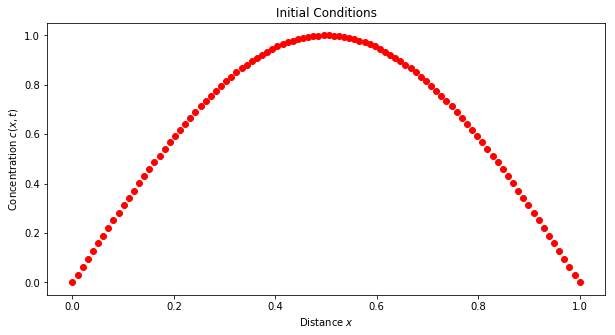

In [4]:
plotIC()

### Set up other simulation parameters
----

We now set:

* `diffusionCoefficient` - the diffusion coefficient
* `dt` - the discrete time step (the formulaic choice of `dt` is needed to satisfy stability constraints)

In [5]:
diffusionCoefficient = 10.0
dt = dx**2/(4*diffusionCoefficient)

Our choice of timestep is restricted:

$$
dt \leq \frac{\Delta x^2}{2 \, D}
$$

### Set up the data structure
----

There are potentially three strategies for storing the results of numerical computations.  One is to store ALL the data, another is to store SOME of the data, and the last is to store NONE of the data except the very last computation.  Each strategy has advantages and disadvantages although all strategies may seem equally difficult to implement.  In this lecture we will design design a data structure that stores all the data.

Let us create a `numpy` array that has one dimension equal to the number of points in our grid and another dimension that is equal to the number of iterations we wish to compute:

In [6]:
arrayWithAllTheData = np.zeros((numberOfPoints,numberOfIterations), dtype='float32')

You can think of the 2D array as having one space axis (the first index, we will use `i` for this one) and one time axis (the second index, we will use `j` for this one).

We will set our initial conditions by assigning the `initialCondition` array to the first row of the `arrayWithAllTheData`.  Note the slicing in the first index so that we can copy the contents of the `initialCondition` into the whole first row with a single assignment statement.

In [7]:
arrayWithAllTheData[:,0] = initialCondition

With our initial conditions in place we need to develop the computational steps to advance our solution in time.  The PDE we are solving (with a constant diffusion coefficient) is:

$$
\frac{\partial c(x,t)}{\partial t} = D \frac{\partial^2 c(x,t)}{\partial x}
$$

we transform this into:

$$
\frac{u_{i,\, j+1} - u_{i,\, j}}{\Delta t} = D \frac{u_{i - 1,\, j} - 2 u_{i,\, j} + u_{i + 1,\, j}}{\Delta x^2}
$$

so that we can algebraically solve for $u_{i+1,\, j}$:

$$
u_{i,\, j+1} = \frac{D \Delta t}{\Delta x^2} \left( u_{i - 1,\, j} - 2 u_{i,\, j} + u_{i + 1,\, j} \right) + u_{i,\, j}
$$

From the expression above you can see that all the terms on the RHS of the expression are at the index $j$ (the last iteration) and all the terms on the LHS are for the $j+1$ index (the next iteration).  This scheme defines a simple method (with a restrictive timestep) for integrating a PDE.  Re-examine the figure below in comparison to the finite difference scheme:

![](./images/grid.png)

$$
u_{i,\, j+1} = \frac{D \Delta t}{\Delta x^2} \left( u_{i - 1,\, j} - 2 u_{i,\, j} + u_{i + 1,\, j} \right) + u_{i,\, j}
$$

To make all of this work we have to proceed as follows:

* Compute the prefactor $D \Delta t/ \Delta x^2$.
* Apply the boundary conditions in the $j$th row of the array.
* Using the $j$ row of the array (plus the boundary conditions), fill in row $j+1$ of the array with values corresponding to the new time $t + \Delta t$ according to the equation above.
* Advance the index and repeat until all rows are filled.
* Visualize the results.

**Advancing the index** and **repeating until the rows are filled** are done in the cell below:

### Write the Solver and Compute the Results
----

In [8]:
for j in range(1,numberOfIterations):
    for i in range(1,numberOfPoints-1):
        arrayWithAllTheData[i,j] = 0 # What should you put here?

### DIY:  Sketch the algorithm up to this point and for the cell below.
----

Doing this will help you visualize the operations and it will increase your ability to make modifications in the future and devise new more compact ways to integrate this PDE.

If you've sketched the algorithm as advised above then you see that in our development of this solution we implicitly set the boundary conditions.  We initialize `arrayWithAllTheData` with `np.zeros` and then compute on all the interior rows/columns.  This creates a condition where all the boundary cells are set to zero and their values remain untouched throughout the computation.

### Plot the results
----

In [9]:
%matplotlib inline
import numpy as np
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt

def plotArray(xPoints, dataArray, rowID=0):
    """
    This function in conjunction with interact() permits
    inspection of the contents of an array, row by row.  This
    is useful for some small tasks such as examining the results
    of a PDE solution.
    """
    x = xPoints
    y = dataArray[:,rowID]
    fig = plt.figure(figsize=(7,4))
    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    axes.set_ylim(0,1)
    axes.plot(x, y, 'ro', label=r"$c(x,t)$")
    axes.legend()
    axes.grid(False)
    plt.show()
    return

In [10]:
interact(plotArray, 
         xPoints=fixed(xPoints), 
         dataArray=fixed(arrayWithAllTheData),
         rowID=(0,numberOfIterations-1,1), );

interactive(children=(IntSlider(value=0, description=u'rowID', max=999), Output()), _dom_classes=('widget-interact',))

### DIY:  Compute a solution where you change the boundary conditions on the LHS to be $c(x=L,t) = 1.0$.

In [ ]:
# Your solver code goes here.

### Optional DIY:  Vectorize the above solution method.


In [ ]:
# Your solver code goes here.

###  Homework
----

Part 1:  Solve the following problem:

$$
\frac{\partial c(x,t)}{\partial t} = D \frac{\partial^2 c(x,t)}{\partial x^2}
$$

with the initial condition 

$$c(x,t=0) = 1.0,$$

over the domain 

$$( x \, \vert \, 0 \le x \le 1.0 ).$$

with zero flux boundary conditions.

Part 2:  Solve the following problem:

$$
\frac{\partial c(x,t)}{\partial t} = \frac{\partial}{\partial x} D(c) \frac{\partial c(x,t)}{\partial x}
$$

with the initial condition:

$$
c(x \leq 0.5 , t=0) = 1.0\\
c(x \gt 0.5 , t=0) = 0.0
$$

with D having the dependence:

$$
D(c) = D_0\cdot c \cdot(1-c)
$$

over the domain:

$$
( x \, \vert \, 0 \le x \le 1.0 )
$$

with zero flux boundary conditions.